✅ Loaded 3 entries from log

Algorithm choices count:
algorithm
zstd    2
SKIP    1
Name: count, dtype: int64

File type distribution:
type
application/octet-stream    1
application/json            1
text/plain                  1
Name: count, dtype: int64

Average metrics per algorithm:
           compression_ratio  comp_time_sec  decomp_time_sec   entropy
algorithm                                                             
SKIP                 1.00000        0.00000         0.000000  7.999645
zstd                 0.00035        0.00034         0.000148  4.019455


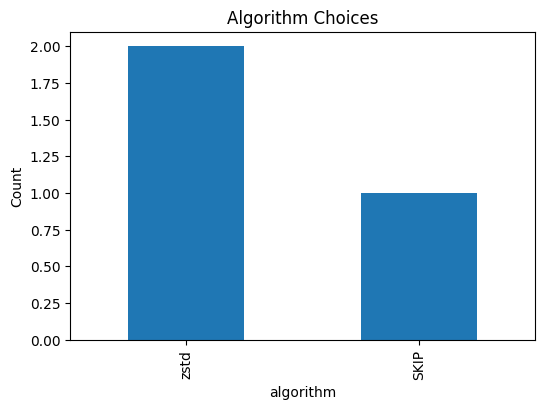

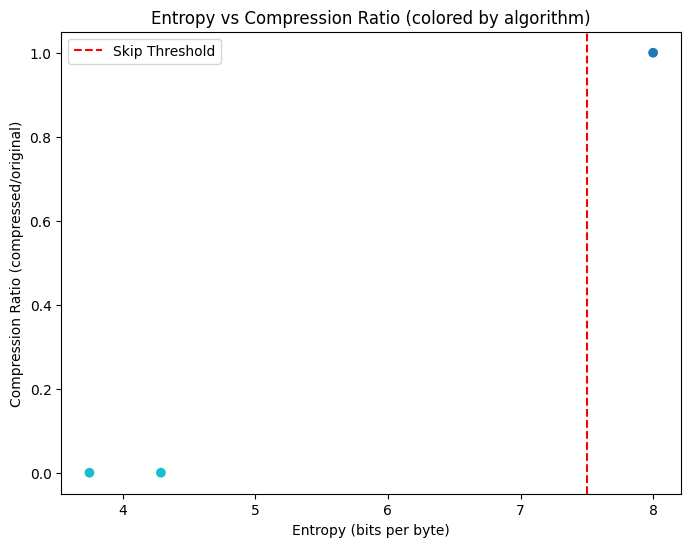

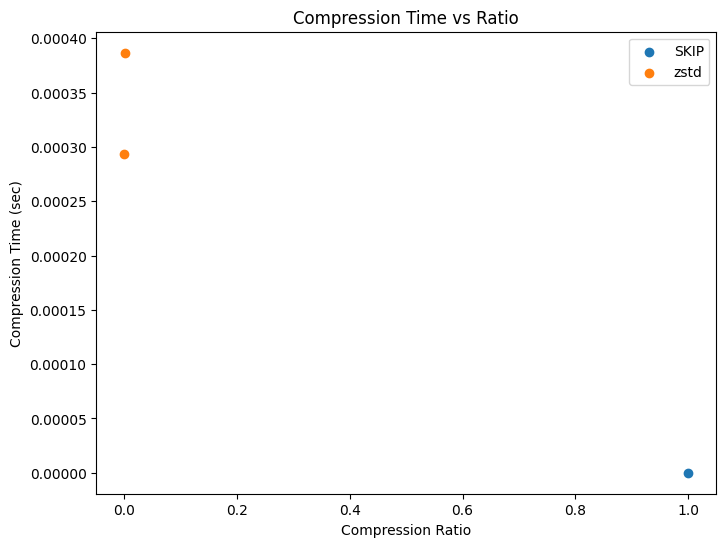


Cross-tab of File Type vs Algorithm:
algorithm                 SKIP  zstd
type                                
application/json             0     1
application/octet-stream     1     0
text/plain                   0     1
Type=application/json, Entropy=4.2, Size=200,000 → Algo=zstd
Type=text/plain, Entropy=3.0, Size=150,000 → Algo=brotli
Type=application/octet-stream, Entropy=7.9, Size=500,000 → Algo=SKIP
Type=video/mp4, Entropy=6.0, Size=50,000,000 → Algo=lz4
Type=image/png, Entropy=5.0, Size=2,000,000 → Algo=zstd


In [ ]:
# --- SmartZip Adaptive Analysis Notebook ---

import pandas as pd
import json
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load the adaptive log
# ----------------------------
log_file = "adaptive_log.jsonl"

with open(log_file) as f:
    records = [json.loads(line) for line in f]

df = pd.DataFrame(records)
print("✅ Loaded", len(df), "entries from log")
df.head()
# ----------------------------
# 2. Basic stats
# ----------------------------
print("\nAlgorithm choices count:")
print(df["algorithm"].value_counts())

print("\nFile type distribution:")
print(df["type"].value_counts())

print("\nAverage metrics per algorithm:")
print(df.groupby("algorithm")[["compression_ratio", "comp_time_sec", "decomp_time_sec", "entropy"]].mean())
# ----------------------------
# 3. Algorithm choices bar chart
# ----------------------------
df["algorithm"].value_counts().plot(kind="bar", figsize=(6,4), title="Algorithm Choices")
plt.ylabel("Count")
plt.show()
# ----------------------------
# 4. Entropy vs Compression Ratio
# ----------------------------
plt.figure(figsize=(8,6))
colors = df["algorithm"].astype("category").cat.codes  # color by algorithm
plt.scatter(df["entropy"], df["compression_ratio"], c=colors, cmap="tab10")

plt.axvline(7.5, color="red", linestyle="--", label="Skip Threshold")
plt.xlabel("Entropy (bits per byte)")
plt.ylabel("Compression Ratio (compressed/original)")
plt.title("Entropy vs Compression Ratio (colored by algorithm)")
plt.legend()
plt.show()
# ----------------------------
# 5. Compression Time vs Ratio
# ----------------------------
plt.figure(figsize=(8,6))
for algo in df["algorithm"].unique():
    subset = df[df["algorithm"] == algo]
    plt.scatter(subset["compression_ratio"], subset["comp_time_sec"], label=algo)

plt.xlabel("Compression Ratio")
plt.ylabel("Compression Time (sec)")
plt.title("Compression Time vs Ratio")
plt.legend()
plt.show()
# ----------------------------
# 6. File Type vs Algorithm
# ----------------------------
print("\nCross-tab of File Type vs Algorithm:")
print(pd.crosstab(df["type"], df["algorithm"]))
# ----------------------------
# 7. SmartZip Decision Simulator
# ----------------------------

def smartzip_decision(file_type: str, entropy: float, size: int) -> str:
    """
    Rule-based SmartZip decision engine (same logic as smartzip_adaptive.py).
    """
    if entropy > 7.5:
        return "SKIP"

    if "json" in file_type or "text" in file_type:
        if entropy < 3.5:
            return "brotli"   # archival mode
        return "zstd"         # balanced mode

    if "audio" in file_type or "video" in file_type or "image" in file_type:
        if size > 5_000_000:
            return "lz4"      # prioritize speed for large media
        return "zstd"

    return "zstd"


# --- Try some simulations ---
scenarios = [
    {"file_type": "application/json", "entropy": 4.2, "size": 200_000},
    {"file_type": "text/plain", "entropy": 3.0, "size": 150_000},
    {"file_type": "application/octet-stream", "entropy": 7.9, "size": 500_000},
    {"file_type": "video/mp4", "entropy": 6.0, "size": 50_000_000},
    {"file_type": "image/png", "entropy": 5.0, "size": 2_000_000},
]

for s in scenarios:
    algo = smartzip_decision(s["file_type"], s["entropy"], s["size"])
    print(f"Type={s['file_type']}, Entropy={s['entropy']}, Size={s['size']:,} → Algo={algo}")
    # ----------------------------
# 8. Decision Boundary Visualization
# ----------------------------
import numpy as np

# Define entropy range and file size buckets
entropy_range = np.linspace(0, 8, 100)
sizes = [100_000, 1_000_000, 50_000_000]  # small, medium, large
file_types = ["text/plain", "application/json", "video/mp4", "image/png", "application/octet-stream"]

fig, axes = plt.subplots(len(file_types), len(sizes), figsize=(15, 12), sharex=True, sharey=True)

for i, ftype in enumerate(file_types):
    for j, size in enumerate(sizes):
        decisions = [smartzip_decision(ftype, e, size) for e in entropy_range]
        axes[i, j].scatter(entropy_range, decisions, c=[{"brotli":"blue","zstd":"green","lz4":"orange","SKIP":"red"}[d] for d in decisions], s=20)
        axes[i, j].set_title(f"{ftype}\nSize={size:,}")
        axes[i, j].set_xlabel("Entropy")
        if j == 0:
            axes[i, j].set_ylabel("Decision")

plt.suptitle("SmartZip Decision Boundaries (Entropy vs Algorithm Choice)", fontsize=14)
plt.tight_layout()
plt.show()
# ----------------------------
# 9. Consistency Check (Logged vs Rule Engine)
# ----------------------------

# Recompute rule-based decision for each log entry
df["predicted_algo"] = df.apply(lambda row: smartzip_decision(row["type"], row["entropy"], row["original_size"]), axis=1)

# Compare actual vs predicted
df["match"] = df["algorithm"] == df["predicted_algo"]

print("\nConsistency check:")
print(df[["file", "type", "entropy", "original_size", "algorithm", "predicted_algo", "match"]])

# Accuracy score
accuracy = df["match"].mean() * 100
print(f"\n✅ Rule engine consistency: {accuracy:.2f}%")

# Confusion matrix (actual vs predicted)
confusion = pd.crosstab(df["algorithm"], df["predicted_algo"], rownames=["Actual"], colnames=["Predicted"])
print("\nConfusion Matrix (Actual vs Predicted):")
print(confusion)
# ----------------------------
# 10. Auto-Tuning Entropy Threshold
# ----------------------------

def smartzip_decision_threshold(file_type: str, entropy: float, size: int, threshold: float) -> str:
    """SmartZip with adjustable entropy threshold for Brotli vs Zstd."""
    if entropy > 7.5:
        return "SKIP"

    if "json" in file_type or "text" in file_type:
        if entropy < threshold:
            return "brotli"
        return "zstd"

    if "audio" in file_type or "video" in file_type or "image" in file_type:
        if size > 5_000_000:
            return "lz4"
        return "zstd"

    return "zstd"

# Grid search over entropy thresholds
thresholds = [x/10 for x in range(20, 50)]  # 2.0 → 5.0 in 0.1 steps
scores = []

for th in thresholds:
    df["predicted_algo"] = df.apply(
        lambda row: smartzip_decision_threshold(row["type"], row["entropy"], row["original_size"], th), axis=1
    )
    accuracy = (df["predicted_algo"] == df["algorithm"]).mean()
    scores.append((th, accuracy))

# Find best threshold
best_th, best_acc = max(scores, key=lambda x: x[1])
print(f"🔍 Best entropy threshold = {best_th:.2f}, Accuracy = {best_acc*100:.2f}%")

# Plot accuracy vs threshold
plt.figure(figsize=(8,5))
plt.plot([s[0] for s in scores], [s[1]*100 for s in scores], marker="o")
plt.axvline(best_th, color="red", linestyle="--", label=f"Best={best_th:.2f}")
plt.xlabel("Entropy Threshold for Brotli vs Zstd")
plt.ylabel("Consistency Accuracy (%)")
plt.title("Tuning Entropy Cutoff")
plt.legend()
plt.show()
# ----------------------------
# 10. Auto-Tuning Entropy Threshold
# ----------------------------

def smartzip_decision_threshold(file_type: str, entropy: float, size: int, threshold: float) -> str:
    """SmartZip with adjustable entropy threshold for Brotli vs Zstd."""
    if entropy > 7.5:
        return "SKIP"

    if "json" in file_type or "text" in file_type:
        if entropy < threshold:
            return "brotli"
        return "zstd"

    if "audio" in file_type or "video" in file_type or "image" in file_type:
        if size > 5_000_000:
            return "lz4"
        return "zstd"

    return "zstd"

# Grid search over entropy thresholds
thresholds = [x/10 for x in range(20, 50)]  # 2.0 → 5.0 in 0.1 steps
scores = []

for th in thresholds:
    df["predicted_algo"] = df.apply(
        lambda row: smartzip_decision_threshold(row["type"], row["entropy"], row["original_size"], th), axis=1
    )
    accuracy = (df["predicted_algo"] == df["algorithm"]).mean()
    scores.append((th, accuracy))

# Find best threshold
best_th, best_acc = max(scores, key=lambda x: x[1])
print(f"🔍 Best entropy threshold = {best_th:.2f}, Accuracy = {best_acc*100:.2f}%")

# Plot accuracy vs threshold
plt.figure(figsize=(8,5))
plt.plot([s[0] for s in scores], [s[1]*100 for s in scores], marker="o")
plt.axvline(best_th, color="red", linestyle="--", label=f"Best={best_th:.2f}")
plt.xlabel("Entropy Threshold for Brotli vs Zstd")
plt.ylabel("Consistency Accuracy (%)")
plt.title("Tuning Entropy Cutoff")
plt.legend()
plt.show()
# ----------------------------
# 11. Auto-Tuning Entropy + Size Thresholds
# ----------------------------

def smartzip_decision_dual(file_type: str, entropy: float, size: int, entropy_th: float, size_th: int) -> str:
    """SmartZip with adjustable entropy & size thresholds."""
    # Skip incompressible
    if entropy > 7.5:
        return "SKIP"

    # Text & JSON
    if "json" in file_type or "text" in file_type:
        if entropy < entropy_th:
            return "brotli"
        return "zstd"

    # Media (audio, video, image)
    if "audio" in file_type or "video" in file_type or "image" in file_type:
        if size > size_th:
            return "lz4"
        return "zstd"

    return "zstd"

# Grid search: entropy 2.0–5.0, size 1MB–20MB
entropy_range = [x/10 for x in range(20, 51)]  # 2.0 to 5.0
size_range = [1_000_000, 5_000_000, 10_000_000, 20_000_000]

best_score = -1
best_params = (None, None)

for et in entropy_range:
    for st in size_range:
        df["predicted_algo"] = df.apply(
            lambda row: smartzip_decision_dual(row["type"], row["entropy"], row["original_size"], et, st),
            axis=1
        )
        acc = (df["predicted_algo"] == df["algorithm"]).mean()
        if acc > best_score:
            best_score = acc
            best_params = (et, st)

print(f"🔍 Best thresholds → Entropy={best_params[0]:.2f}, Size={best_params[1]/1_000_000:.1f}MB, Accuracy={best_score*100:.2f}%")

# Visualize accuracy for entropy vs size cutoff
import numpy as np
acc_matrix = np.zeros((len(entropy_range), len(size_range)))

for i, et in enumerate(entropy_range):
    for j, st in enumerate(size_range):
        df["predicted_algo"] = df.apply(
            lambda row: smartzip_decision_dual(row["type"], row["entropy"], row["original_size"], et, st),
            axis=1
        )
        acc_matrix[i, j] = (df["predicted_algo"] == df["algorithm"]).mean()

plt.figure(figsize=(8,6))
plt.imshow(acc_matrix*100, cmap="viridis", aspect="auto",
           extent=[min(size_range)/1_000_000, max(size_range)/1_000_000, min(entropy_range), max(entropy_range)],
           origin="lower")
plt.colorbar(label="Accuracy (%)")
plt.scatter(best_params[1]/1_000_000, best_params[0], color="red", marker="x", label="Best")
plt.xlabel("Size Threshold (MB)")
plt.ylabel("Entropy Threshold")
plt.title("SmartZip Accuracy Heatmap (Entropy vs Size)")
plt.legend()
plt.show()
# ----------------------------
# 12. Auto-Recalibration Loop (Self-Learning SmartZip)
# ----------------------------

def tune_thresholds(df):
    """Run grid search to find best entropy & size thresholds."""
    entropy_range = [x/10 for x in range(20, 51)]  # 2.0 to 5.0
    size_range = [1_000_000, 5_000_000, 10_000_000, 20_000_000]

    best_score, best_params = -1, (None, None)

    for et in entropy_range:
        for st in size_range:
            preds = df.apply(
                lambda row: smartzip_decision_dual(row["type"], row["entropy"], row["original_size"], et, st),
                axis=1
            )
            acc = (preds == df["algorithm"]).mean()
            if acc > best_score:
                best_score, best_params = acc, (et, st)
    
    return best_params, best_score


def auto_recalibrate(log_file="adaptive_log.jsonl"):
    """Load logs and update SmartZip thresholds automatically."""
    # Load log data
    with open(log_file) as f:
        records = [json.loads(line) for line in f]
    df = pd.DataFrame(records)

    # Find best thresholds
    (best_entropy, best_size), best_acc = tune_thresholds(df)
    print(f"🔄 Auto-Recalibration → Entropy={best_entropy:.2f}, Size={best_size/1_000_000:.1f}MB, Accuracy={best_acc*100:.2f}%")

    # Save thresholds persistently
    thresholds = {"entropy_threshold": best_entropy, "size_threshold": best_size}
    with open("smartzip_thresholds.json", "w") as f:
        json.dump(thresholds, f, indent=2)

    return thresholds, best_acc


# --- Run auto recalibration ---
thresholds, acc = auto_recalibrate()
print("\n📌 Updated thresholds saved in smartzip_thresholds.json")


